### Analyze SBB Schedule Using Graph Algorithms

We are going to employ the graph algorithms (BFS, shortest-path) to explore Swiss Railways schedules.

#### Notes
The code provides Swiss public transport stops as adjacency graph.

Get the graph:

In [1]:
import fahrplan
sbb = fahrplan.latest

Display some data:

In [2]:
len(sbb)

33396

In [3]:
sbb['Romanshorn']

{'Amriswil': 5,
 'Egnach': 3,
 'Kreuzlingen Hafen': 14,
 'Neukirch-Egnach': 2,
 'Romanshorn': 3,
 'Romanshorn (See)': 5,
 'Romanshorn Autoquai': 6,
 'Romanshorn, Bahnhof': 3,
 'St. Gallen': 18,
 'Uttwil': 3,
 'Wittenbach': 12}

The graph contains direct non-stop connections between stops, including transfers, with connection time in minutes.

The graph only records whether two stations are directly connected with each other by at least one connection. It omits any information on
  * lines
  * time of day
  * service schedules

So, some edges may be the consequence of special effects such as end-of-day connections, weekend night service, and the like.

Also, since each edge distance is recorded in minutes from departure to arrival, concatenating multiple legs will underestimate actual travelling time, as the stop time
is ignored.


### Run Shortest-Path

In [4]:
import graphs

path = graphs.shortest_path(sbb, 'Romanshorn', 'Bern')
path

{'path': [('Romanshorn', 0),
  ('Amriswil', 5),
  ('Weinfelden', 10),
  ('Frauenfeld', 10),
  ('Islikon', 3),
  ('Rickenbach-Attikon', 2),
  ('Wiesendangen', 1),
  ('Oberwinterthur', 2),
  ('Winterthur', 2),
  ('Stettbach', 11),
  ('Zürich Stadelhofen', 4),
  ('Zürich HB', 2),
  ('Olten', 28),
  ('Bern', 26)],
 'length': 106}

#### Visualize Stops

In [5]:
from fahrplan import gtfs_reader
# Read stop coordinates from GTFS.
stops = gtfs_reader.read_stops('fahrplan/gtfs_fp2025_2025-02-13', 'name')

In [6]:
def read_stops(src, dest, algo=graphs.shortest_path):
    """Computes a path from src to dest using the given algorithm and returns a tuple
       for each stop containing (stop_name, latitude, longitude, minutes)."""
    path = algo(sbb, src, dest)
    # DFS only returns stops, but not additional information.
    if algo == graphs.find_path_dfs:
        for stop in path:
            info = stops[stop]
            yield(info.name, float(info.lat), float(info.lon), 0)
        return
    for stop in path['path']:
        info = stops[stop[0]]
        yield(info.name, float(info.lat), float(info.lon), stop[1])

list(read_stops('Romanshorn', 'Bern', graphs.find_path_bfs))

[('Romanshorn', 47.565521, 9.37937276, 0),
 ('St. Gallen', 47.42317726, 9.36989554, 18),
 ('St. Margrethen SG', 47.45321735, 9.63825825, 17),
 ('Zürich HB', 47.3781762, 8.54021154, 160),
 ('Bern', 46.9488311, 7.43912853, 56)]

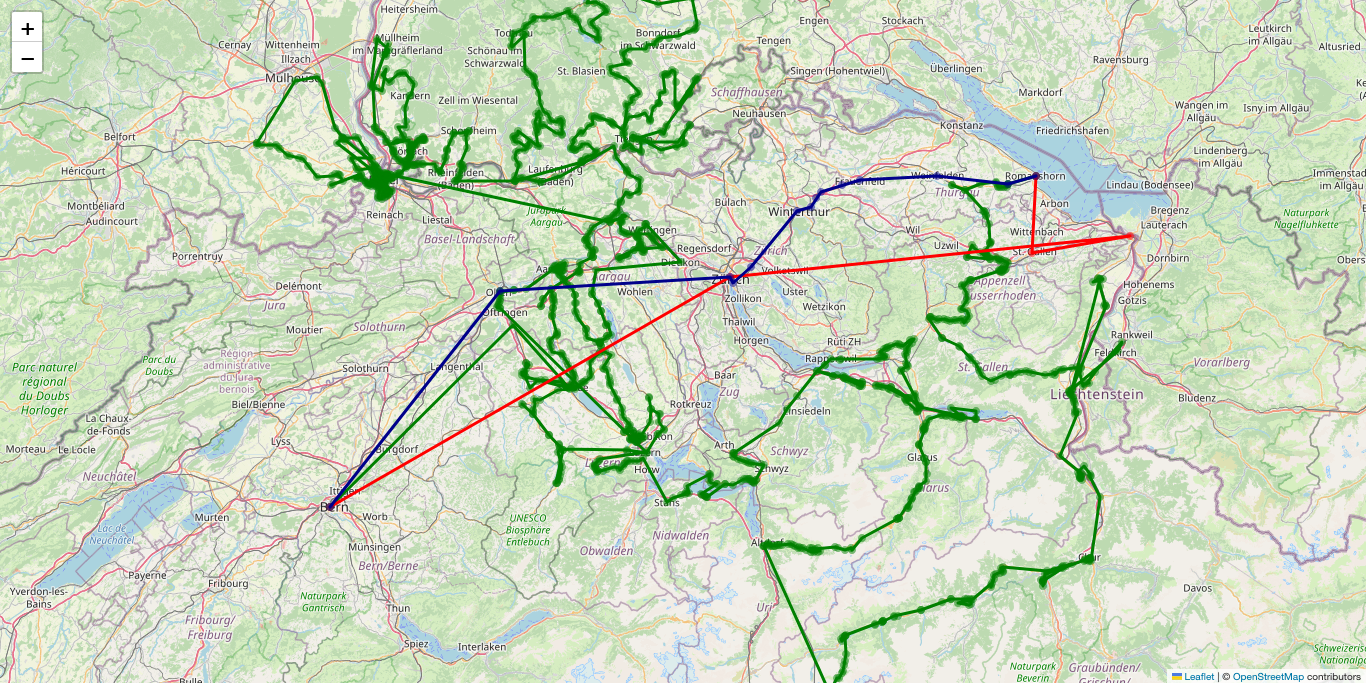

In [7]:
#%pip install folium pillow selenium
import folium
import folium.features


def drawPath(map, path, tooltip, color):
    """Draws a polyline of the path on the map."""
    path = list(path) # reify generator
    line = folium.features.PolyLine([(info[1], info[2]) for info in path], tooltip=tooltip, color=color).add_to(map)
    map.fit_bounds(line.get_bounds())
    for info in path:
        folium.CircleMarker(
            location=[info[1], info[2]],
            radius=4,
            color=color,
            stroke=False,
            fill=True,
            fill_opacity=0.5,
            opacity=1,
            popup=info[0],
            tooltip=info[0]
        ).add_to(map)


map = folium.Map()

origin = 'Romanshorn'
destination = 'Bern'
drawPath(map, read_stops(origin, destination, graphs.find_path_dfs), "DFS", "green")
drawPath(map, read_stops(origin, destination, graphs.find_path_bfs), "BFS", "red")
drawPath(map, read_stops(origin, destination, graphs.shortest_path), "Dijkstra", "darkblue")

# map

# Export to still image in order for github to render.
# Folium interactive content cannot be rendered on github.
import io
from PIL import Image

img_data = map._to_png(5)
Image.open(io.BytesIO(img_data))